# Machine Learning

Since we are predicting genres, we need to use a classifier, as there are a set number of genres existing and genres itself is a categorical variable.

## Setup

### Make needed imports

In [0]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import *
from google.colab import files
from io import BytesIO
import numpy as np
from sklearn.linear_model import *
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import *
from sklearn.ensemble import GradientBoostingClassifier
from google.colab import drive

In [2]:
!pip install scikit-multilearn

### Get Drive Setup

In [3]:
drive.mount('drive')
data_dir = "drive/My Drive/301 Project/Data/"
df_movies = pd.read_csv(data_dir + "cleaned_dataframe.csv")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [4]:
df_movies.head()

,Unnamed: 0,Animation,Horror,Mystery,Fantasy,Romance,TV Movie,Family,Documentary,Western,Science Fiction,Foreign,Crime,Adventure,Thriller,Comedy,War,Drama,History,Action,Music,id,original_title,budget,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count,collection,Composer,Director,Screenplay,cast,keywords,rating_average,userId_who_like
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,862,Toy Story,30000000,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar_Animation_Studios,373554033.0,81.0,NaN,7.7,5415.0,Toy_Story_Collection,NaN,John_Lasseter,Alec_Sokolow,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,jealousy toy boy friendship friends rivalry bo...,3.598930,2103 6177 6525 8659 9328 9682 11214 13839 1523...
1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,8844,Jumanji,65000000,When siblings Judy and Peter discover an encha...,17.015539,TriStar_Pictures Teitler_Film Interscope_Commu...,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,NaN,James_Horner,Joe_Johnston,Jim_Strain,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,board_game disappearance based_on_children's_b...,3.760163,7016 7144 8659 9547 13399 17808 24266 25209 26...
2,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,949,Heat,60000000,"Obsessive master thief, Neil McCauley leads a ...",17.924927,Regency_Enterprises Forward_Pass Warner_Bros.,187436818.0,170.0,A Los Angeles Crime Saga,7.7,1886.0,NaN,Elliot_Goldenthal,Michael_Mann,Michael_Mann,Al_Pacino Robert_De_Niro Val_Kilmer Jon_Voight...,robbery detective bank obsession chase shootin...,3.905544,174 346 362 384 523 557 609 624 773 825 959 11...
3,3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,710,GoldenEye,58000000,James Bond must unmask the mysterious head of ...,14.686036,United_Artists Eon_Productions,352194034.0,130.0,No limits. No fears. No substitutes.,6.6,1194.0,James_Bond_Collection,Eric_Serra,Martin_Campbell,Bruce_Feirstein,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,cuba falsely_accused secret_identity computer_...,2.740334,2073 2709 2967 4241 4389 4916 5463 5811 5980 8...
4,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1408,Cutthroat Island,98000000,"Morgan Adams and her slave, William Shaw, are ...",7.284477,Le_Studio_Canal+ Laurence_Mark_Productions Met...,10017322.0,119.0,The Course Has Been Set. There Is No Turning B...,5.7,137.0,NaN,NaN,Renny_Harlin,Robert_King,Geena_Davis Matthew_Modine Frank_Langella Maur...,exotic_island treasure map ship scalp pirate,3.710181,15 65 68 98 115 151 153 193 231 288 326 340 34...


### This is used to determine what if you want to run certain tests that will take a while

Type **yes** or **no**

In [85]:
should_run_tests = input("Do you want to run tests? ")
if should_run_tests == "y" or should_run_tests == "yes":
  should_run_tests = True
else:
  should_run_tests = False

Do you want to run tests? n


### Setup DataFrame for ML

In [0]:
df_movies["collection"] = df_movies["collection"].fillna(df_movies["original_title"])

### Scoring Methods for Multi-label

In [0]:
def my_score_with_average_and_scoring(scoring, average): 
  def my_score_with_average_set(y_true, y_pred, **kwargs):
    return scoring(y_true, y_pred, average=average, **kwargs)
  return my_score_with_average_set

def my_f1_score(y_true, y_pred, **kwargs):
  return f1_score(y_true, y_pred, average='micro', **kwargs)

hamming_score_scorer = make_scorer(hamming_score)
hamming_loss_scorer = make_scorer(hamming_loss)

### Prediction Columns for later

In [0]:
predictor_columns = [
    "Fantasy",
    "Science Fiction",
    "Action",
    "Romance",
    "Horror",
    "Western",
    "Comedy",
    "Crime",
    "Foreign",
    "Music",
    "Documentary",
    "History",
    "Adventure",
    "Mystery",
    "TV Movie",
    "Drama",
    "War",
    "Thriller",
    "Family",
    "Animation"
]

## Actual ML

### Ensembles (stacking) as many models as wanted together

In [0]:
def ensemble_model(ct, X_train, y_train, models):
  for model in models:
    if (type(model) != tuple and type(model) != list) or len(model) < 2:
      raise InvalidModelException("Model {} is invalid".format(model))
    else:
      model.fit(X_train, y_train)
      print("Fit model {}".format(model[0]))

  estimator = StackingClassifier(
    models,
    final_estimator=RidgeClassifier()
  )
  
  estimator.fit(X=X_train, y=y_train)
  print("Stacking model fit done")
  return estimator

### Assembler

Gathers needed data from columns for training, sets up the models, and optionally returns the DataFrame for the predictions or reports a cross validation score of the estimator

In [0]:
def assemble(
    ohe=[], 
    tfidf=[], 
    scale=[], 
    show_error = False, 
    download="", 
    model=logistic_model,
    cts=[],
    scoring=make_scorer(my_score_with_average_and_scoring(f1_score, "micro")),
    do_grid_search=(False, None),
    y_train_cols=predictor_columns,
    return_df=False,
    silent=False,
    full_silent=False,
):
  if not silent and not full_silent:
    print("Using model:", model)
  features = ohe +  tfidf + scale
  if not silent and not full_silent:
    print("Using features:", features)

  # Training data
  df_train = df_movies[features + y_train_cols].dropna()
  X_train = df_train[features]
  y_train = df_train[y_train_cols]

  if len(cts) == 0:
    ct = make_column_transformer(
        (StandardScaler(), scale),
        (OneHotEncoder(handle_unknown="ignore"), ohe),
        remainder="drop",
    )
    estimator = model([ct], X_train, y_train)
  else:
    estimator = model(cts, X_train, y_train)

  if not silent and not full_silent:
    print("Model fit...")

  if show_error:
    if not silent and not full_silent:
      print("Starting cross val")
    score = (cross_validate(
          estimator,
          X=X_train,
          y=y_train,
          scoring=scoring,
          cv=5
      )['test_score']).mean()
    if not silent and not full_silent:
      print("Score for features {}: {}".format(features, score))
    else:
      if not full_silent:
        print(score)
    return score


In [0]:
def make_pass_column_transformer(tup):
  return make_column_transformer(
      tup,
      remainder="passthrough"
  )

def create_default_tdidf_transformers(column_list, sep=False):
  if sep:
    return [make_pass_column_transformer(
        (TfidfVectorizer(), col)
      ) for col in column_list]

  tuple_list = [(TfidfVectorizer(), col) for col in column_list]
  return make_column_transformer(
      *tuple_list,
      remainder="passthrough"
  )

def combine_column_transformers(cts):
  new_l = []
  for ct in cts:
    for transform in ct.transformers:
      new_l.append((transform[1], transform[2]))
  if len(new_l) == 0:
    return []
  return make_column_transformer(
      *new_l,
      remainder="passthrough"
  )

default_tdidf_columns = ["keywords", "overview", 
                         "production_companies", "original_title", "cast"]

general_tfidf_transformer = create_default_tdidf_transformers(default_tdidf_columns)

In [14]:
df_movies.head()

,Unnamed: 0,Animation,Horror,Mystery,Fantasy,Romance,TV Movie,Family,Documentary,Western,Science Fiction,Foreign,Crime,Adventure,Thriller,Comedy,War,Drama,History,Action,Music,id,original_title,budget,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count,collection,Composer,Director,Screenplay,cast,keywords,rating_average,userId_who_like
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,862,Toy Story,30000000,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar_Animation_Studios,373554033.0,81.0,NaN,7.7,5415.0,Toy_Story_Collection,NaN,John_Lasseter,Alec_Sokolow,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,jealousy toy boy friendship friends rivalry bo...,3.598930,2103 6177 6525 8659 9328 9682 11214 13839 1523...
1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,8844,Jumanji,65000000,When siblings Judy and Peter discover an encha...,17.015539,TriStar_Pictures Teitler_Film Interscope_Commu...,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,NaN,James_Horner,Joe_Johnston,Jim_Strain,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,board_game disappearance based_on_children's_b...,3.760163,7016 7144 8659 9547 13399 17808 24266 25209 26...
2,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,949,Heat,60000000,"Obsessive master thief, Neil McCauley leads a ...",17.924927,Regency_Enterprises Forward_Pass Warner_Bros.,187436818.0,170.0,A Los Angeles Crime Saga,7.7,1886.0,NaN,Elliot_Goldenthal,Michael_Mann,Michael_Mann,Al_Pacino Robert_De_Niro Val_Kilmer Jon_Voight...,robbery detective bank obsession chase shootin...,3.905544,174 346 362 384 523 557 609 624 773 825 959 11...
3,3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,710,GoldenEye,58000000,James Bond must unmask the mysterious head of ...,14.686036,United_Artists Eon_Productions,352194034.0,130.0,No limits. No fears. No substitutes.,6.6,1194.0,James_Bond_Collection,Eric_Serra,Martin_Campbell,Bruce_Feirstein,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,cuba falsely_accused secret_identity computer_...,2.740334,2073 2709 2967 4241 4389 4916 5463 5811 5980 8...
4,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1408,Cutthroat Island,98000000,"Morgan Adams and her slave, William Shaw, are ...",7.284477,Le_Studio_Canal+ Laurence_Mark_Productions Met...,10017322.0,119.0,The Course Has Been Set. There Is No Turning B...,5.7,137.0,NaN,NaN,Renny_Harlin,Robert_King,Geena_Davis Matthew_Modine Frank_Langella Maur...,exotic_island treasure map ship scalp pirate,3.710181,15 65 68 98 115 151 153 193 231 288 326 340 34...


In [0]:
def give_certain_models(label_model, classifier_model,
                        label_model_kwargs={}, classifier_model_kwargs={},
                        use_dense=False):
  def specific_model_to_use(cts, X_train, y_train):
    if use_dense:
      model = make_pipeline(
          *cts,
          FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
          label_model(
              classifier_model(**classifier_model_kwargs), **label_model_kwargs
          )
      )
    else:
      model = make_pipeline(
          *cts,
          label_model(
              classifier_model(**classifier_model_kwargs), **label_model_kwargs
          )
      )
    # print(model.steps[0][1].transformers)
    # print(X_train)
    model.fit(X=X_train, y=y_train)
    return model
  return specific_model_to_use

### Tests on Multilabel classificaition

#### OneVsRest

In [0]:
from sklearn.multiclass import OneVsRestClassifier

if should_run_tests:
  assemble(
      tfidf=default_tdidf_columns,
      show_error=True,
      model=give_certain_models(OneVsRestClassifier, LogisticRegression),
      cts=[general_tfidf_transformer]
  )

- Naive Bayes not a good idea, since our tests are not independent. Also, doesn't work well with tfidf stuff, since they process and store too much (maxed RAM).
- Label Powerset a no-go
- GradientBoosterClassifier no-go

#### General Tester

In [0]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multiclass import *
from sklearn.ensemble import *
from sklearn.svm import LinearSVC
from sklearn.linear_model import *

label_models = [OneVsRestClassifier]

classifier_models = [LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier, RidgeClassifier]

default_tdidf_columns = ["keywords", "production_companies", "original_title", "cast"]
temp_columns = ["keywords"]
temp_test_cols = create_default_tdidf_transformers(default_tdidf_columns)

def run_different_combo_models(labels, classifiers):
  for label in labels:
    for classifier in classifiers:
      print("Running label {} and classifier {}:".format(label, classifier), end=" ")
      if type(classifier) == type:
        assemble(
          tfidf=default_tdidf_columns,
          show_error=True,
          model=give_certain_models(
              label, classifier,
              use_dense=(False)
          ),
          cts=[temp_test_cols],
          silent=True
        )
      else:
        assemble(
          tfidf=default_tdidf_columns,
          show_error=True,
          model=give_certain_models(
              label[0], classifier[0],
              label_model_kwargs=label[1], classifier_model_kwargs=classifier[1],
              use_dense=(False)
          ),
          cts=[temp_test_cols],
          silent=True
        )

if should_run_tests:
  run_different_combo_models(label_models, classifier_models)

#### Graphing Optimization tests

In [0]:
def graph_values(x, y, graph_type, x_label="", y_label="", graph_name=""):
  ax = pd.Series(x, index=y).sort_values().plot(kind=graph_type, title=graph_name)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

#### KNN Optimizer

In [0]:
n_range = list(range(1, 100, 4))
value_range = []
if should_run_tests:
  for i, val in enumerate(n_range):
    score = assemble(
        tfidf=default_tdidf_columns,
        show_error=True,
        model=give_certain_models(
            OneVsRestClassifier, KNeighborsClassifier,
            classifier_model_kwargs={"n_neighbors" : val}
        ),
        cts=[create_default_tdidf_transformers(["keywords"])],
        full_silent=True
      )
    value_range.append(score)
  graph_values(value_range, n_range, "line", "n_neighbors", "F1 Score", "KNN Optimization")

  print("Best n {}".format(pd.Series(value_range, index=n_range).idxmin()))

### SGDClassifier Optimizer

In [20]:
alpha_range = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
value_range = []
if should_run_tests:
  for i, val in enumerate(alpha_range):
    score = assemble(
        tfidf=default_tdidf_columns,
        show_error=True,
        model=give_certain_models(
            OneVsRestClassifier, SGDClassifier,
            classifier_model_kwargs={
                "alpha" : val,
            }
        ),
        cts=[temp_test_cols],
        silent=True
      )
    value_range.append(score)

  graph_values(value_range, alpha_range, "line", "alpha", "F1 Score", "SDG Optimization")
  print("Best alpha {}".format(pd.Series(value_range, index=alpha_range).idxmin()))

Using features: ['keywords', 'production_companies', 'original_title', 'cast']
0.10025606066483068
Using features: ['keywords', 'production_companies', 'original_title', 'cast']
0.09773597804584772
Using features: ['keywords', 'production_companies', 'original_title', 'cast']
0.09466275551762926
Using features: ['keywords', 'production_companies', 'original_title', 'cast']
0.09361840114813234
Using features: ['keywords', 'production_companies', 'original_title', 'cast']
0.09122664947054032
Using features: ['keywords', 'production_companies', 'original_title', 'cast']
0.09358831115938096


### Feature Testing

In [0]:
columns_to_ignore = set(['Unnamed: 0', "id"] + predictor_columns)
features_to_test_template = set(df_movies.columns) - columns_to_ignore
testing_types = {
  'Composer' : "ohe",
  'Director' : "ohe",
  'Screenplay' : "ohe",
  'budget' : "scale",
  'cast' : "tfidf",
  'collection' : "ohe",
  'keywords' : "tfidf",
  'original_title' : "tfidf",
  'overview' : "tfidf",
  'popularity' : "scale",
  'production_companies' : "tfidf",
  'rating_average' : "scale",
  'revenue' : "scale",
  'runtime' : "scale",
  'userId_who_like' : "tfidf",
  'vote_average' : "scale",
  'vote_count' : "scale",
  'tagline' : "tfidf",
  'mod_overview' : "tfidf"
}

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  
stopwords = set(nltk.corpus.stopwords.words('english'))

if "mod_overview" not in df_movies.columns:
  def create_new_column_without_stopwords(df, column_before, column_after=None):
    words_series = (
      df[column_before].
      str.lower().
      str.replace("[^\w\s]", "").
      str.split()
    )

    def get_new_words(words):
      return " ".join([w for w in words if w not in stopwords])

    if column_after == None:
      df[column_before] = words_series.apply(get_new_words)
    else:
      df[column_after] = words_series.apply(get_new_words)

  _temp_df = pd.DataFrame(df_movies[["id", "overview"]].copy().dropna())
  create_new_column_without_stopwords(_temp_df, "overview", "mod_overview")
  df_movies = df_movies.merge(_temp_df.drop("overview", axis=1), how='left', on="id")
  testing_types["mod_overview"] = "tfidf"

### Test Features Individually

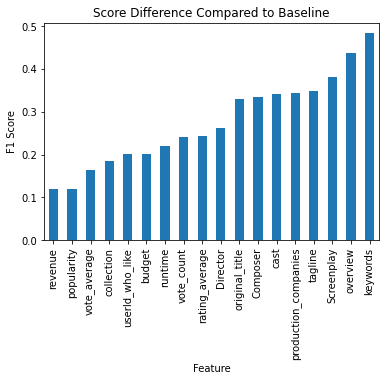

In [98]:
interesting_features_to_test = testing_types.keys()
for_sure_features = []
to_ignore = []

scores_series = pd.Series()
baseline_score = 0

for interest in interesting_features_to_test:
  if interest in for_sure_features or interest in to_ignore:
    continue
  if len(interest) > 0:
    columns_testing = for_sure_features + [interest]
  else:
    columns_testing = for_sure_features
  tfidf_cols = [col for col in columns_testing if testing_types[col] == "tfidf"]
  ohe_cols = [col for col in columns_testing if testing_types[col] == "ohe"]
  scale_cols = [col for col in columns_testing if testing_types[col] == "scale"]
  tfidf_col_transformer, ohe_col_transformer, scale_col_transformer = [], [], []

  if len(tfidf_cols) > 0:
    tfidf_col_transformer = [create_default_tdidf_transformers(tfidf_cols)]
  if len(ohe_cols) > 0:
    ohe_col_transformer = [make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        remainder="passthrough"
    )]
  if len(scale_cols) > 0:
    scale_col_transformer = [make_column_transformer(
        (StandardScaler(), scale_cols),
        remainder="passthrough"
    )]

  score = assemble(
    ohe=ohe_cols,
    scale=scale_cols,
    tfidf=tfidf_cols,
    show_error=True,
    scoring=make_scorer(my_score_with_average_and_scoring(f1_score, "micro")),
    model=give_certain_models(
        OneVsRestClassifier, SGDClassifier,
    ),
    cts=(
        [combine_column_transformers(
            tfidf_col_transformer + 
            ohe_col_transformer + 
            scale_col_transformer
        )]
    ),
    full_silent=True
  )

  if len(interest) > 0:
    scores_series = scores_series.append(pd.Series(score, index=[interest]))
  else:
    baseline_score = score

diffs = (scores_series - baseline_score)
graph_values(list(diffs), diffs.index, "bar", "Feature", "F1 Score", "Score Difference Compared to Baseline")

### Model Testing

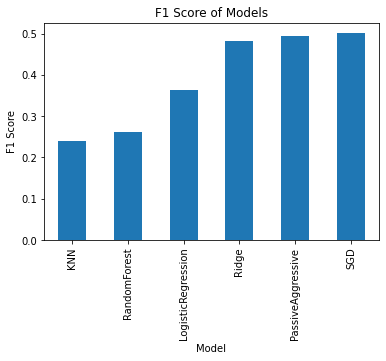

In [93]:
features_to_test = [
    "keywords", "overview", "Screenplay", 
    "cast", "tagline", "production_companies",
    "Composer", "colleciton"
]

models = [
          (LogisticRegression, {"max_iter" : 1000}, "LogisticRegression"), 
          (KNeighborsClassifier, {"n_neighbors" : 80}, "KNN"), 
          (SGDClassifier, { "alpha" : 0.0001 }, "SGD"), 
          (RandomForestClassifier, { "max_depth" : 30, "random_state" : 0 }, 
           "RandomForest"
          ),
          (PassiveAggressiveClassifier, { "C" : 1 }, "PassiveAggressive"),
          (RidgeClassifier, { "alpha" : 1 }, "Ridge")
]

scores_series = pd.Series()
baseline_score = 0

for model in models:
  tfidf_cols = [col for col in features_to_test if testing_types[col] == "tfidf"]
  ohe_cols = [col for col in features_to_test if testing_types[col] == "ohe"]
  scale_cols = [col for col in features_to_test if testing_types[col] == "scale"]
  tfidf_col_transformer, ohe_col_transformer, scale_col_transformer = [], [], []

  if len(tfidf_cols) > 0:
    tfidf_col_transformer = [create_default_tdidf_transformers(tfidf_cols)]
  if len(ohe_cols) > 0:
    ohe_col_transformer = [make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        remainder="passthrough"
    )]
  if len(scale_cols) > 0:
    scale_col_transformer = [make_column_transformer(
        (StandardScaler(), scale_cols),
        remainder="passthrough"
    )]

  score = assemble(
    ohe=ohe_cols,
    scale=scale_cols,
    tfidf=tfidf_cols,
    show_error=True,
    model=give_certain_models(
        OneVsRestClassifier, model[0],
        classifier_model_kwargs=model[1]
    ),
    cts=(
        [combine_column_transformers(
            tfidf_col_transformer + 
            ohe_col_transformer + 
            scale_col_transformer
        )]
    ),
    full_silent=True
  )

  scores_series = scores_series.append(pd.Series(score, index=[model[2]]))

graph_values(list(scores_series), scores_series.index, "bar", 
             "Model", "F1 Score", "F1 Score of Models")